# Homework 6
#### Yufeng Yuan
#### yy208@duke.edu

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
import cv2
from copy import deepcopy
import os
import skimage.filters as filters
from time import gmtime, strftime, sleep
from PIL import ImageFilter
from scipy import interpolate as interp
import skimage.color as cp
from scipy.fftpack import dct, idct
from PIL import Image
from scipy.fftpack import dct, idct
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/home/arthur/Softwares/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [65]:
def grabImage(sid=1, imres=8, fm=1, cameraNumber=7, iters=1):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    for i in range(iters):
        #print(i)
        cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
        subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                       stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                       stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        pop=pop[250416:]
        pop=np.reshape(pop,(2174,3864))
       # pop=np.append(pop[:,2060:] ,pop[:,:2060],axis=1)
    return pop

def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI

def demosaic(raw):
    # weird here, for the 1780 boundary, there are differnt color sensor for these two regions
    raw_left, raw_right = raw[:, :744], raw[:, 744:]
    red_left = raw_left[::2, ::2]
    green_left = raw_left[1::2, 0::2]
    blue_left = raw_left[1::2, 1::2]
    red_right = raw_right[1::2, 0::2]
    green_right = raw_right[1::2, 1::2]
    blue_right = raw_right[0::2, 1::2]
    
    red = np.append(red_left, red_right, axis=1)
    green = np.append(green_left, green_right, axis=1)
    blue = np.append(blue_left, blue_right, axis=1)
    jpg_image = np.dstack((red, green, blue))
    #jpg_image = 800 * np.log(jpg_image) / np.max(np.log(jpg_image)) - 550
    jpg_image = 255 * np.sqrt(jpg_image) / np.sqrt(np.max(jpg_image))
    jpg_image = jpg_image.astype(np.uint8)
    jpg_image = np.repeat(np.repeat(jpg_image, 2, axis=1), 2, axis=0)
    return jpg_image

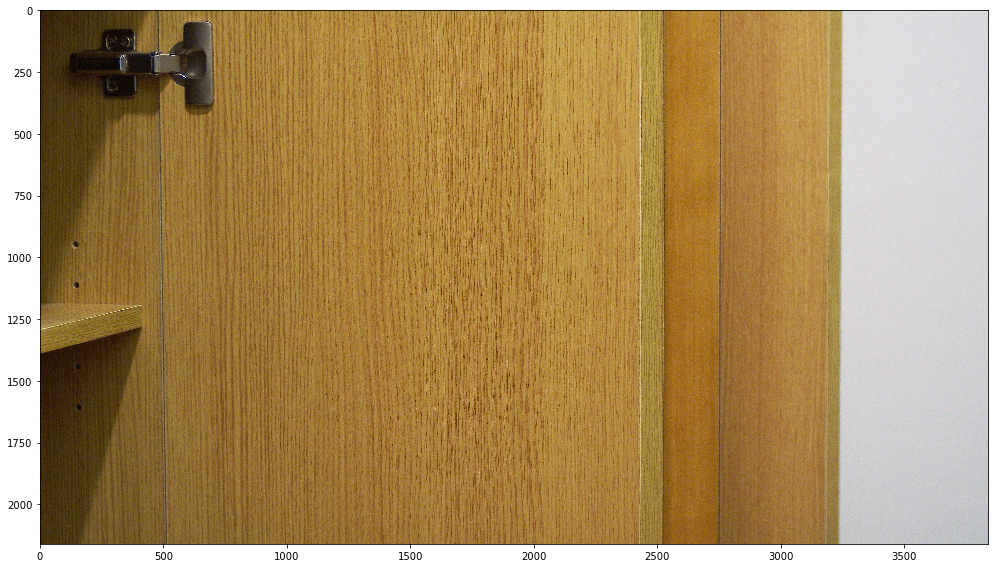

In [30]:
a = grabImage(fm=1, cameraNumber=7)
imio.imshow(a)

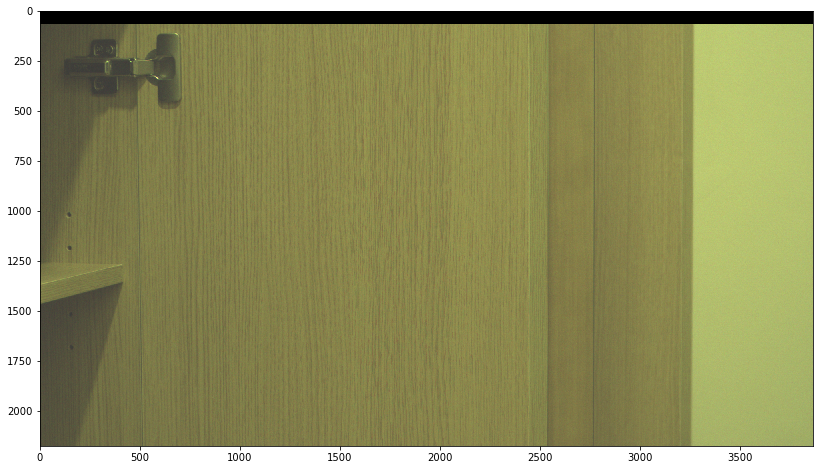

In [31]:
# Step 1
b = grabImage(fm=2, cameraNumber=7)
b = demosaic(b)
tmp = deepcopy(b)
b[:, 3120:] = tmp[:, :744]
b[:, :3120] = tmp[:, 744:]
b = trans.rotate(b, 180)
plt.imshow(b)

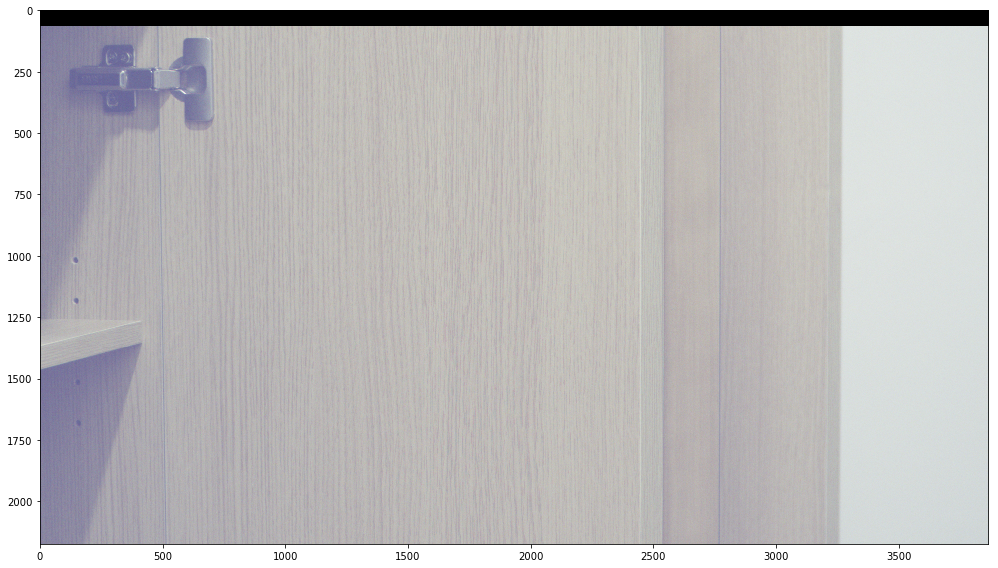

In [33]:
c = adjustColor(b,rc=0.7,bc=1.2,gc=.7,gain=4,contrast=.5)
imio.imshow(c)

/home/arthur/Softwares/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


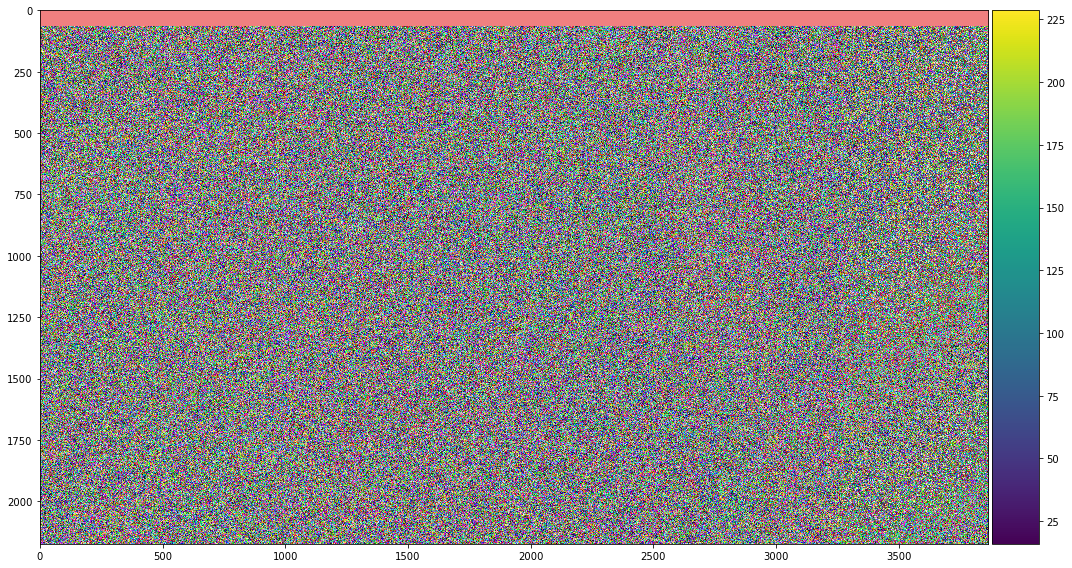

In [34]:
# Step 2
e=cp.rgb2ycbcr(c)
imio.imshow(e)

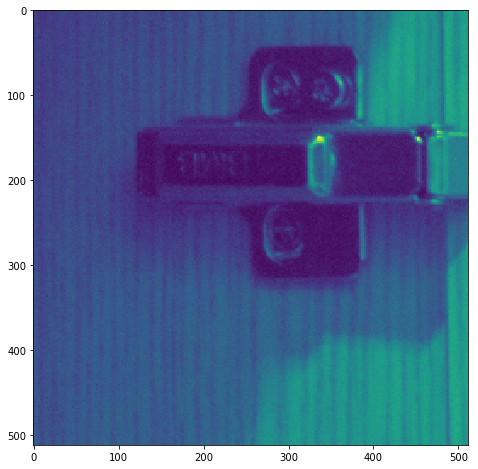

In [38]:
# Step 3
Y, Cb, Cr = e[:, :, 0], e[:, :, 1], e[:, :, 2]
compressed_Cr = Cr[::2, ::2]
compressed_Cb = Cb[::2, ::2]
plt.imshow(Y[100:612, :512])

After down-sampling Cr and Cb plane by a factor of 2, the size of the image should be reduced by 50%

There are 247266 zero coefficients in Y plane, the size of Y plane is reduced by 94.0%


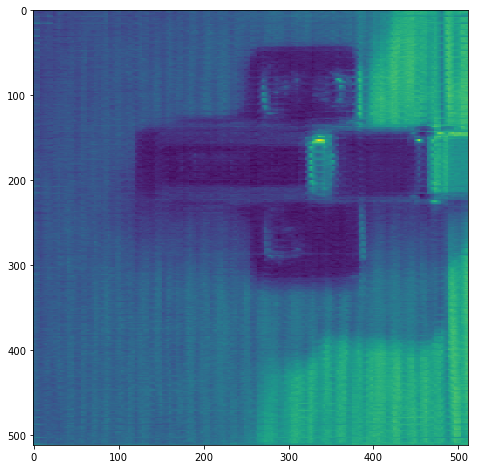

In [66]:
# Step 4 and 5
def dct2D(x):
	tmp = dct(x, type=2 ,norm='ortho').transpose()
	return dct(tmp, type=2 ,norm='ortho').transpose()

def idct2D(x):
	tmp = idct(x, type=2 ,norm='ortho').transpose()
	return idct(tmp, type=2 ,norm='ortho').transpose()

def compress(Y):
    # apply dct compression to a sub-region of 512 by 512 image
    sub_Y = deepcopy(Y[100:612, :512])
    seg_Y = np.zeros([64*64, 8, 8])
    for i in range(64):
        for j in range(64):
            seg_Y[i*64 + j, :, :] = sub_Y[i*8:i*8+8, j*8:j*8+8]
    dct_co = dct2D(seg_Y)
    q_matrix = np.array([
        16, 11, 10, 16, 24, 40, 51, 61,
        12, 12, 14, 19, 26, 58, 60, 55,
        14, 13, 16, 24, 40, 57, 69, 56,
        14, 17, 22, 29, 51, 87, 80, 62,
        18, 22, 37, 56, 68, 109, 103, 77,
        24, 35, 55, 64, 81, 104, 113, 92,
        49, 64, 78, 87, 103, 121, 120, 101,
        72, 92, 95, 98, 112, 100, 103, 99
    ])
    q_matrix = q_matrix.reshape(8, 8)
    mask = np.round(dct_co / q_matrix)
    zeros = np.sum(mask == 0)
    dct_co[mask == 0] = 0
    print('There are '+str(zeros)+' zero coefficients in Y plane, the size of Y plane is reduced by '+str(np.round(zeros/262144*100))+'%')
    dct_co = np.round(dct_co)
    return dct_co

def restore(dct_co):
    # apply inverse dct to restore the original image
    seg_Y = idct2D(dct_co)
    sub_Y = np.zeros([512, 512])
    for i in range(64):
        for j in range(64):
            sub_Y[i*8:i*8+8, j*8:j*8+8] = np.round(seg_Y[i*64 + j, :, :]) 
    return sub_Y

dct_co = compress(Y)
sub_Y = restore(dct_co)
plt.imshow(sub_Y)

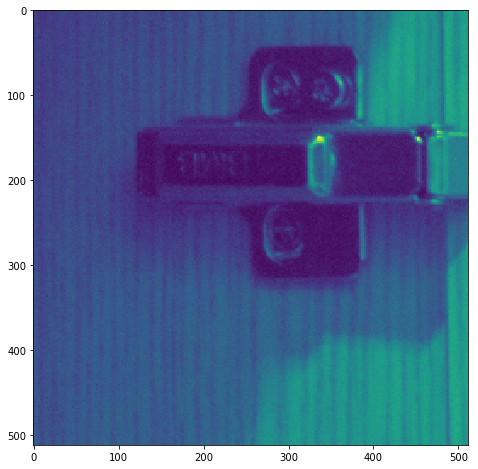

In [61]:
plt.imshow(Y[100:612, :512])

The original Y plane look clearer and sharper, while the rebuilt one seems blured and the boundary of the blocks of sub-images can be noticed

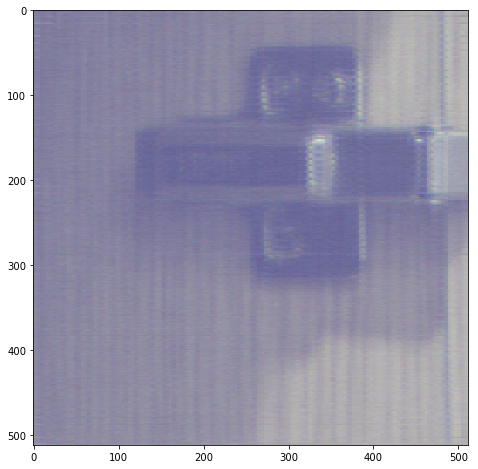

In [63]:
# Step 6
Cr = np.repeat(np.repeat(compressed_Cr, 2, axis=1), 2, axis=0)
Cb = np.repeat(np.repeat(compressed_Cb, 2, axis=1), 2, axis=0)
img = np.zeros([512, 512, 3])
img[:, :, 0] = sub_Y
img[:, :, 1] = Cb[100:612, :512]
img[:, :, 2] = Cr[100:612, :512]
compressed_img = cp.ycbcr2rgb(img)
plt.imshow(compressed_img)

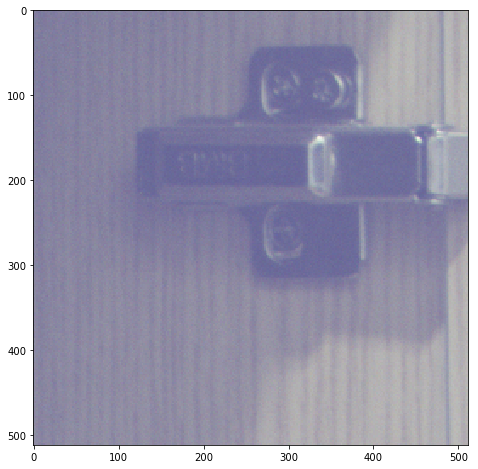

In [64]:
plt.imshow(c[100:612, :512])

Conclusion here is similar to the previous one. The original Y plane look clearer and sharper, while the rebuilt one seems blured and the boundary of the blocks of sub-images can be noticed. The original one has much better image quality